In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df_train=pd.read_csv(r"C:\Users\plpvk\OneDrive\Documents\Amazon ML challenge\student_resource\dataset\train.csv")
df_train.set_index('sample_id',inplace=True)
print(df_train.head())
print(f"Training data shape:{df_train.shape}")
df_test=pd.read_csv(r"C:\Users\plpvk\OneDrive\Documents\Amazon ML challenge\student_resource\dataset\test.csv")
print(df_test.head())
df_test.set_index('sample_id',inplace=True)
print(f"Test data shape:{df_test.shape}")

                                             catalog_content  \
sample_id                                                      
33127      Item Name: La Victoria Green Taco Sauce Mild, ...   
198967     Item Name: Salerno Cookies, The Original Butte...   
261251     Item Name: Bear Creek Hearty Soup Bowl, Creamy...   
55858      Item Name: Judee’s Blue Cheese Powder 11.25 oz...   
292686     Item Name: kedem Sherry Cooking Wine, 12.7 Oun...   

                                                  image_link  price  
sample_id                                                            
33127      https://m.media-amazon.com/images/I/51mo8htwTH...   4.89  
198967     https://m.media-amazon.com/images/I/71YtriIHAA...  13.12  
261251     https://m.media-amazon.com/images/I/51+PFEe-w-...   1.97  
55858      https://m.media-amazon.com/images/I/41mu0HAToD...  30.34  
292686     https://m.media-amazon.com/images/I/41sA037+Qv...  66.49  
Training data shape:(75000, 3)
   sample_id                  

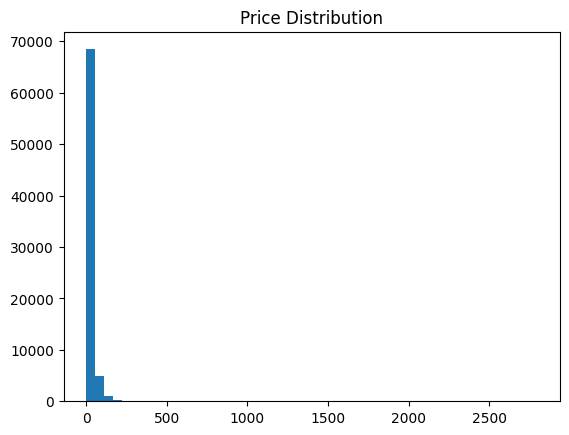

lower bound : -25.949999999999996 , upper bound : 61.37
outliers (premium products):5524
Price range : $0.13 to $2796.0
Average price : $23.647654


In [ ]:
plt.hist(df_train["price"],bins=50)
plt.title("Price Distribution")
plt.show()


Q1 = df_train['price'].quantile(0.25)
Q3 = df_train['price'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_train[(df_train['price'] < Q1 - 1.5 * IQR) | (df_train['price'] > Q3 + 1.5 * IQR)]
print(f"lower bound : {Q1-1.5*IQR} , upper bound : {Q3+1.5*IQR}")
print(f"outliers (premium products):{outliers.shape[0]}")


print(f"Price range : ${df_train['price'].min()} to ${df_train['price'].max()}")
print(f"Average price : ${df_train['price'].mean()}")

In [ ]:
import spacy
from tqdm import tqdm
from collections import Counter
import numpy as np

def brand_prem(catalog_texts):
    nlp = spacy.load("en_core_web_sm")
    docs = [nlp(text.lower()) for text in tqdm(catalog_texts, desc="sparsing texts")]

    brands = []
    for doc in tqdm(docs, desc="Extracting brands"):
        brands.extend([ent.text for ent in doc.ents if ent.label_ == "ORG"])
    brand_counts = Counter(brands)
    top_brands = [brand for brand, count in brand_counts.items() if count >= 10]
    sorted_top_brands = sorted(top_brands, key=lambda x: brand_counts[x], reverse=True)

    premium_words = []
    for doc in tqdm(docs, desc="Extracting adjectives"):
        premium_words.extend([token.text.lower() for token in doc if token.pos_ == "ADJ"])
    premium_counts = Counter(premium_words)
    top_premium_words = [word for word, count in premium_counts.items() if count >= 20]
    sorted_top_premium_words = sorted(top_premium_words, key=lambda x: premium_counts[x], reverse=True)

    return sorted_top_brands, sorted_top_premium_words

catalog_texts = df_train['catalog_content'].fillna("").astype(str)
top_brands, top_premium_words = brand_prem(catalog_texts)

np.save("/kaggle/working/top_brands.npy", top_brands)
np.save("/kaggle/working/top_premium_words.npy", top_premium_words)

In [ ]:
print(top_brands[:5])
print(top_premium_words[:5])

In [14]:
import re
from tqdm import tqdm
import pandas as pd

def extract_text_features(text: str) -> dict:
    features = {}

    features["text_length"] = len(text)

    for brand in top_brands:
        features[f'has_{brand}'] = brand.lower() in text.lower()

    ipq_match = re.search(r'IPQ[:\s]*(\d+)', text, re.IGNORECASE)
    features['ipq'] = int(ipq_match.group(1)) if ipq_match else 1

    premium_count = 0
    for word in top_premium_words:
        if word in text.lower():
            premium_count += 1
    features['premium_keywords'] = premium_count

    return features

'''text_features = pd.DataFrame([
    extract_text_features(text)
    for text in tqdm(df_train['catalog_content'].fillna("").astype(str), desc="Extracting text features")
])'''

'text_features = pd.DataFrame([\n    extract_text_features(text)\n    for text in tqdm(df_train[\'catalog_content\'].fillna("").astype(str), desc="Extracting text features")\n])'

In [10]:
import spacy
from sklearn.preprocessing import FunctionTransformer

nlp = spacy.load("en_core_web_sm")

def spacy_cleaner(texts):
    cleaned = []
    for text in texts:
        doc = nlp(text.lower())
        tokens = [
            token.lemma_ for token in doc
            if not token.is_stop and not token.is_punct and token.lemma_.strip()
        ]
        cleaned.append(" ".join(tokens))
    return cleaned
spacy_transformer = FunctionTransformer(spacy_cleaner, validate=False)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


tfidf_transformer=TfidfVectorizer(
    max_features=1000,
    ngram_range=(1,2),
    min_df=5,
    max_df=0.8,
    stop_words='english'
)

text_pipeline = Pipeline([
    ('spacy_clean', spacy_transformer),
    ('tfidf', TfidfVectorizer())
])

scaler=StandardScaler()

preprocessor=ColumnTransformer(
    transformers=[
        ('text',text_pipeline,"catalog_content"),
        ('num',StandardScaler(),["Value"])
    ]
)
preprocessor.fit(df_train)


In [ ]:
X_transformed=preprocessor.transform(df_train)

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import torch
import numpy as np
from transformers import ViTImageProcessor, ViTModel
from concurrent.futures import ThreadPoolExecutor, as_completed
from rich.progress import track
import time
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTModel.from_pretrained('google/vit-base-patch16-224')
model.to(device)
model.eval()

def extract_vit_features_fixed(image_url, retries=3):
    """Extract ViT features with proper GPU handling"""
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
    }
    
    for attempt in range(retries):
        try:
            response = requests.get(image_url, headers=headers, timeout=10, stream=True)
            
            if response.status_code == 200:
                image = Image.open(BytesIO(response.content)).convert('RGB')
                
                # Resize to 224x224 for ViT
                if image.size != (224, 224):
                    image = image.resize((224, 224), Image.Resampling.LANCZOS)
                
                inputs = processor(images=image, return_tensors="pt")
                
                # Move inputs to GPU
                inputs = {k: v.to(device) for k, v in inputs.items()}
                
                with torch.no_grad():
                    outputs = model(**inputs)
                    features = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
                
                return features, True
                
            elif response.status_code == 403:
                time.sleep(1)  # Rate limiting
                
        except Exception as e:
            if attempt < retries - 1:  # Don't sleep on last attempt
                time.sleep(random.uniform(0.5, 2.0))
    
    return np.zeros(768), False

def extract_all_image_features(urls, batch_size=1000, max_workers=32):
    """Extract ViT features for all URLs with progress tracking"""
    features_list = []
    success_flags = []
    
    print(f"Processing {len(urls)} images with {max_workers} workers...")
    
    def process_single(url):
        return extract_vit_features_fixed(url)
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        futures = {executor.submit(process_single, url): i for i, url in enumerate(urls)}
        
        for future in track(as_completed(futures), total=len(urls), description="Extracting image features"):
            features, success = future.result()
            features_list.append(features)
            success_flags.append(success)
    
    return np.array(features_list), np.array(success_flags)


In [ ]:
print("=== EXTRACTING TRAINING IMAGE FEATURES ===")
train_image_urls = df_train['image_link'].fillna('').tolist()
train_image_features, train_success_flags = extract_all_image_features(train_image_urls)

print(f"Training images successfully processed: {train_success_flags.sum()}/{len(train_success_flags)}")
print(f"Success rate: {train_success_flags.sum()/len(train_success_flags)*100:.2f}%")



# Quick analysis of extracted features
print("\n=== FEATURE ANALYSIS ===")
print(f"Training features shape: {train_image_features.shape}")
print(f"Training features - Min: {train_image_features.min():.4f}, Max: {train_image_features.max():.4f}")
print(f"Training features - Mean: {train_image_features.mean():.4f}, Std: {train_image_features.std():.4f}")
print(f"Non-zero features in first image: {np.count_nonzero(train_image_features[0])}/768")

In [9]:
np.save('/kaggle/working/train_image_features.npy', train_image_features)
np.save('/kaggle/working/train_success_flags.npy', train_success_flags)

In [ ]:


# PROCESS ALL TEST IMAGES
print("\n=== EXTRACTING TEST IMAGE FEATURES ===")
test_image_urls = df_test['image_link'].fillna('').tolist()
test_image_features, test_success_flags = extract_all_image_features(test_image_urls)

print(f"Test images successfully processed: {test_success_flags.sum()}/{len(test_success_flags)}")
print(f"Success rate: {test_success_flags.sum()/len(test_success_flags)*100:.2f}%")

np.save('/kaggle/working/test_image_features.npy', test_image_features)
np.save('/kaggle/working/test_success_flags.npy', test_success_flags)
print("Test image features saved!")'''

In [8]:
import xgboost as xgb
model = xgb.XGBRegressor(
    n_estimators=800,           
    learning_rate=0.1,          
    max_depth=8,                
    subsample=0.8,
    colsample_bytree=0.8,
    colsample_bylevel=0.8,      
    reg_alpha=0.1,              
    reg_lambda=1.0,
    gamma=0,                    
    min_child_weight=1,         
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

In [3]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred)
    smape_score = np.mean(diff / denominator) * 100
    return smape_score

In [4]:
image_features=np.load(r"C:\Users\plpvk\OneDrive\Documents\Amazon ML challenge\train_image_features.npy",allow_pickle=True)
image_flags=np.load(r"C:\Users\plpvk\OneDrive\Documents\Amazon ML challenge\train_success_flags.npy",allow_pickle=True)
import pickle
with open(r"C:\Users\plpvk\OneDrive\Documents\Amazon ML challenge\text_features.pkl","rb") as f:
    text_features=pickle.load(f)

In [5]:
from scipy.sparse import csr_matrix, hstack

image_sparse = csr_matrix(image_features.astype(np.float32))
text_sparse = csr_matrix(text_features.astype(np.float32))
X_transformed = np.load(r"C:\Users\plpvk\OneDrive\Documents\Amazon ML challenge\X_transformed.npy", allow_pickle=True)
X_transformed = X_transformed.item()  
X_final = hstack([X_transformed.astype(np.float32), image_sparse, text_sparse])


In [6]:
y_final=np.log1p(df_train["price"])
y_final.head()

sample_id
33127     1.773256
198967    2.647592
261251    1.088562
55858     3.444895
292686    4.211979
Name: price, dtype: float64

In [9]:
model.fit(X_final,y_final)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=None, colsample_bytree=0.8,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=-1,
             num_parallel_tree=None, ...)

In [13]:
preprocessor=np.load(r"C:\Users\plpvk\OneDrive\Documents\Amazon ML challenge\preprocessor.pkl",allow_pickle=True)
top_brands=np.load(r"C:\Users\plpvk\OneDrive\Documents\Amazon ML challenge\text_features.pkl",allow_pickle=True)
top_premium_words=np.load(r"C:\Users\plpvk\OneDrive\Documents\Amazon ML challenge\top_premium_words.npy",allow_pickle=True)

C:\Users\plpvk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator FunctionTransformer from version 1.2.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\plpvk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.2.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\p

In [46]:
text_features_test = pd.DataFrame([
    extract_text_features(text)
    for text in tqdm(df_test['catalog_content'].fillna("").astype(str), desc="Extracting test text features")
])


Extracting test text features:   5%|▌         | 3866/75000 [01:08<21:07, 56.14it/s]  


KeyboardInterrupt: 

In [20]:
Xtest_transformed=preprocessor.transform(df_test)

In [21]:
test_image_features=np.load(r"C:\Users\plpvk\OneDrive\Documents\Amazon ML challenge\test_image_features.npy",allow_pickle=True)

In [55]:
with open(r"C:\Users\plpvk\OneDrive\Documents\Amazon ML challenge\text_features.pkl","rb") as f:
    train_text_features=pickle.load(f)

In [57]:

text_features_test = train_text_features.reindex(columns=train_text_features.columns, fill_value=0)
print(text_features_test.shape)
print(train_text_features.shape)

(75000, 449)
(75000, 449)


In [59]:
test_text_sparse=csr_matrix(text_features_test.astype(np.float32))
test_image_sparse=csr_matrix(test_image_features.astype(np.float32))
Xtest_transformed=csr_matrix(Xtest_transformed.astype(np.float32))

In [60]:
Xtest_final=hstack([Xtest_transformed,test_image_sparse,test_text_sparse])

In [ ]:
print(X_transformed.shape,Xtest_transformed.shape)
print(image_features.shape,test_image_features.shape)
print(text_features_test.shape,train_text_features)

In [91]:
y_pred=model.predict(Xtest_final)

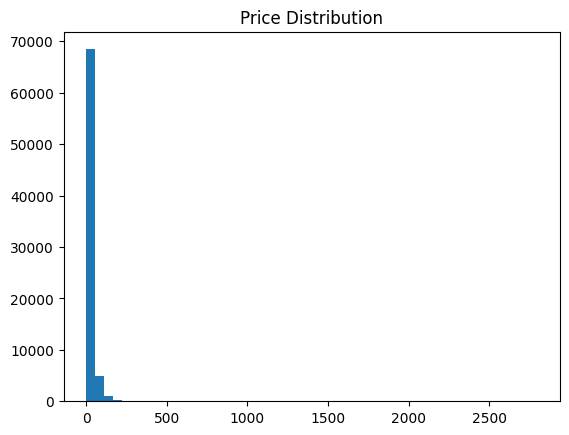

lower bound : -25.949999999999996 , upper bound : 61.37
outliers (premium products):5524
Price range : $0.13 to $2796.0
Average price : $23.647654


In [72]:
plt.hist(df_train["price"],bins=50)
plt.title("Price Distribution")
plt.show()
Q1 = df_train['price'].quantile(0.25)
Q3 = df_train['price'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_train[(df_train['price'] < Q1 - 1.5 * IQR) | (df_train['price'] > Q3 + 1.5 * IQR)]
print(f"lower bound : {Q1-1.5*IQR} , upper bound : {Q3+1.5*IQR}")
print(f"outliers (premium products):{outliers.shape[0]}")
print(f"Price range : ${df_train['price'].min()} to ${df_train['price'].max()}")
print(f"Average price : ${df_train['price'].mean()}")

In [95]:
y_pred_exp=np.expm1(y_pred)
print(y_pred.min(),y_pred.max())
print(y_pred_exp.min(),y_pred_exp.max())

0.60088885 5.376398
0.82373905 215.24199


lower bound : -5.980001211166382 , upper bound : 30.580002069473267
outliers (premium products):5884
Price range : $0.8199999928474426 to $215.24000549316406
Average price : $14.50905990600586


0.82

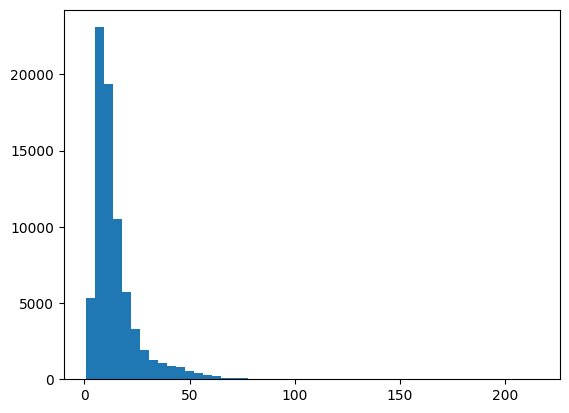

In [106]:
y_pred_new=np.round(y_pred_exp,decimals=2)
y_pred_series=pd.Series(y_pred_new)
plt.hist(y_pred_series,bins=50)
Q1 = y_pred_series.quantile(0.25)
Q3 = y_pred_series.quantile(0.75)
IQR = Q3 - Q1
outliers = y_pred_series[(y_pred_series< Q1 - 1.5 * IQR) | (y_pred_series> Q3 + 1.5 * IQR)]
print(f"lower bound : {Q1-1.5*IQR} , upper bound : {Q3+1.5*IQR}")
print(f"outliers (premium products):{outliers.shape[0]}")


print(f"Price range : ${y_pred_series.min()} to ${y_pred_series.max()}")
print(f"Average price : ${y_pred_series.mean()}")
y_pred_new.min()

lower bound : -5.980001211166382 , upper bound : 30.580002069473267
outliers (premium products):0
Price range : $1.0 to $215.24000549316406
Average price : $14.509063720703125


215.24

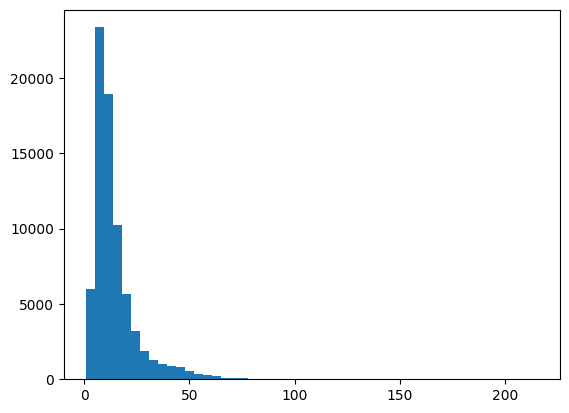

In [105]:
y_pred_sec = np.clip(y_pred_exp, 1.0, 1000.0)
y_pred_new=np.round(y_pred_sec,decimals=2)
y_pred_series=pd.Series(y_pred_new)
plt.hist(y_pred_series,bins=50)
Q1 = y_pred_series.quantile(0.25)
Q3 = y_pred_series.quantile(0.75)
IQR = Q3 - Q1
outliers = y_pred_series[(y_pred< Q1 - 1.5 * IQR) | (y_pred> Q3 + 1.5 * IQR)]
print(f"lower bound : {Q1-1.5*IQR} , upper bound : {Q3+1.5*IQR}")
print(f"outliers (premium products):{outliers.shape[0]}")


print(f"Price range : ${y_pred_series.min()} to ${y_pred_series.max()}")
print(f"Average price : ${y_pred_series.mean()}")
y_pred_new.max()

In [107]:
submission = pd.DataFrame({
    "sample_id": df_test.index,
    "price": y_pred_new
})
submission.to_csv("submission2.csv", index=False)